In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import Stemmer
import time
from sentence_transformers import SentenceTransformer

c:\Users\jsdew\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read files
df_train = pd.read_csv('./input/train.csv', encoding="ISO-8859-1", nrows=100000)
df_test = pd.read_csv('./input/test.csv', encoding="ISO-8859-1", nrows=100000)
df_pro_desc = pd.read_csv('./input/product_descriptions.csv', encoding="ISO-8859-1", nrows=100000)

In [4]:
# Combine train and test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

In [5]:
# Stemming function
stemmer = Stemmer.Stemmer('english')
def str_stemmer(s):
    if isinstance(s, str):
        return " ".join([stemmer.stemWord(word) for word in s.lower().split()])
    else:
        return ""

# Apply stemming
df_all['search_term'] = df_all['search_term'].map(lambda x: str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x: str_stemmer(x))

# Merge columns to get one column with all text
df_all['combined_text'] = df_all['search_term'] + " " + df_all['product_title'] + " " + df_all['product_description']

In [ ]:
# Encode combined text column
encoding_model = SentenceTransformer("paraphrase-mpnet-base-v2")
def process_batches(data, batch_size):
    num_batches = np.ceil(len(data) / batch_size)
    all_encoded_texts = []
    for i in range(int(num_batches)):
        batch = data[i*batch_size:(i+1)*batch_size]
        encoded_batch = encoding_model.encode(batch.tolist(), show_progress_bar=True)
        all_encoded_texts.append(encoded_batch)
        np.save(f'encoded_batch_{i}.npy', encoded_batch)
    return np.vstack(all_encoded_texts)

# Process only the first x rows for clustering
text_features = process_batches(df_all['combined_text'], batch_size=1000)


In [6]:
#np.save('text_features.npy', text_features)
loaded_text_features = np.load('text_features.npy')

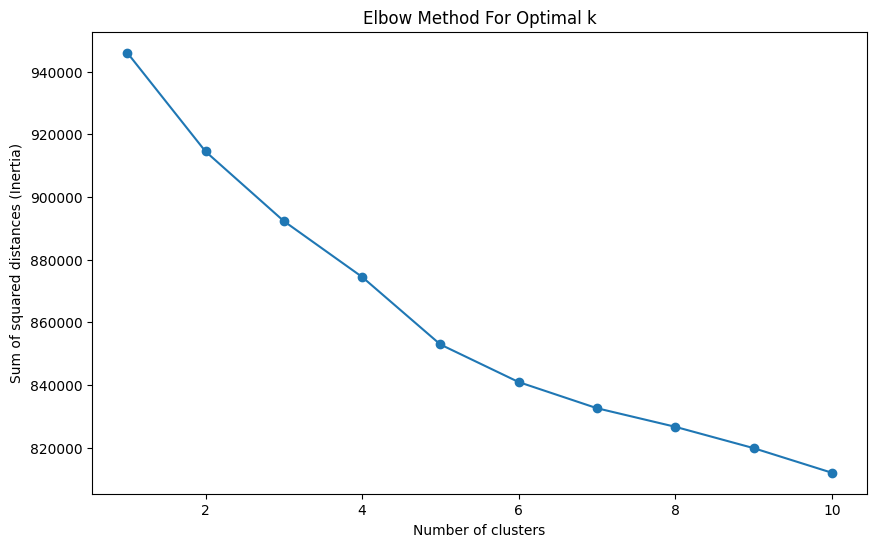

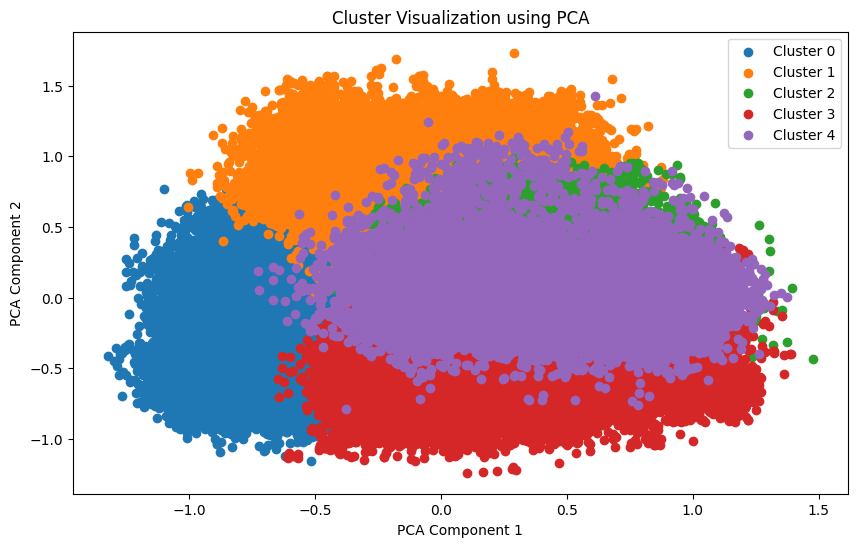

In [10]:
# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(loaded_text_features)
    sse.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

# Perform clustering on vectors
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(loaded_text_features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(loaded_text_features)

# Create a DataFrame for easy plotting
df_plot = pd.DataFrame()
df_plot['PCA1'] = reduced_features[:, 0]
df_plot['PCA2'] = reduced_features[:, 1]
df_plot['Cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    clustered_data = df_plot[df_plot['Cluster'] == cluster]
    plt.scatter(clustered_data['PCA1'], clustered_data['PCA2'], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization using PCA')
plt.legend()
plt.show()


# Add cluster labels to the subset DataFrame
df_all['Cluster'] = cluster_labels


In [13]:
start_time = time.time()

num_train = df_train.shape[0]

def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())

df_all['len_of_query'] = df_all['search_term'].map(lambda x: len(x.split())).astype(np.int64)


# Feature interaction with clusters
# Advanced feature interactions with clusters
key_features = ['len_of_query']
df_all['Cluster'] = df_all['Cluster'].astype(str)  # Ensure cluster is categorical if needed

for feature in key_features:
    df_all[f'{feature}_by_cluster'] = df_all[feature] * df_all['Cluster']


# Ensure the new features are included in the training and validation sets

# Create a new feature that combines the search term, product title, cluster, and product description
df_all['product_info'] = df_all['search_term'] + "\t" + df_all['product_title'] + "\t" + df_all['product_description'] + "\t" + df_all['Cluster'].astype(str)

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

# Drop unnecessary columns
df_all = df_all.drop(['search_term', 'product_title', 'product_description', 'product_info', 'combined_text'], axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id', 'relevance'], axis=1).values

# Split the training data into training and validation sets (80-20 split)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model on the new training set and evaluate it on the validation set
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train_split, y_train_split)

# Predictions on the validation set
y_val_pred = clf.predict(X_val_split)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
print("RMSE on validation set:", rmse)
print("Process finished --- %s seconds ---" % (time.time() - start_time))


RMSE on validation set: 0.4817307372582251
Process finished --- 7.163140773773193 seconds ---
